**Kaggle Username: marchellouisrany**

**Name: Marchellouis Rany**  
**Student ID: 47446730**

# 1. Initial Setup

## 1.1 Loading the necessaries libraries.

In [1]:
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight, check_random_state
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Seting the random seed for ease of replication
np.random.seed(2215)
sklearn.utils.check_random_state(2215)
tf.random.set_seed(2215)

## 1.2 Setting up the dataset

In [2]:
# Creating the root path
root = Path('living-thing-classification-coarse/public')

In [3]:
# Some potentially useful functions for reading data from files from the lecturer.

def load_target_names(path='living-thing-classification-coarse/public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset

def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y

Checking out the `class` and the `family` from the coarse and fine.

In [4]:
fine_names, coarse_names = load_target_names()
print(coarse_names)
print(fine_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']
['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


## 1.3 Creating the Datasets for Conventional Machine Learning

### 1.3.1 Datasets for coarse

We are setting the training data to 15% of the entire data due to the lack of computing power.

In [5]:
X_train_coarse, y_train_coarse = create_dataset_sklearn('train', fine_grained = False, percent = 0.15)
X_val_coarse, y_val_coarse = create_dataset_sklearn('val', fine_grained = False, percent = 1)
X_test_coarse, y_test_coarse = create_dataset_sklearn('test', fine_grained = False, percent = 1)

Checking the shapes of each dataset.

In [6]:
print(f'Training dataset - Features: {X_train_coarse.shape}, Label: {y_train_coarse.shape}')
print(f'Validation dataset - Features: {X_val_coarse.shape}, Label: {y_val_coarse.shape}')
print(f'Testing dataset - Features: {X_test_coarse.shape}, Label: {y_test_coarse.shape}')

Training dataset - Features: (15000, 2304), Label: (15000,)
Validation dataset - Features: (50000, 2304), Label: (50000,)
Testing dataset - Features: (50000, 2304), Label: (50000,)


Checking the balance of the data.

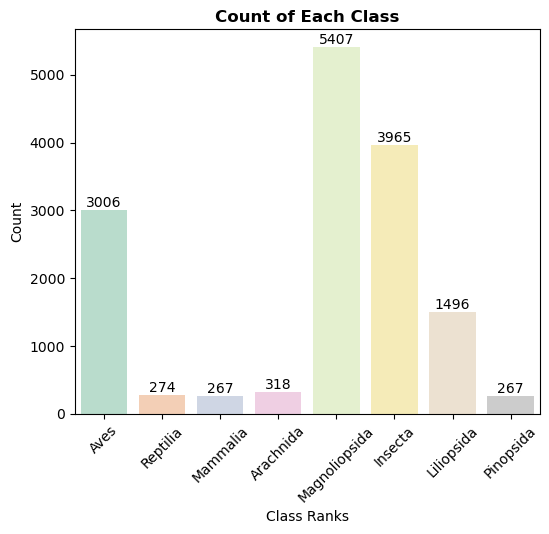

In [7]:
# adjusting the plot size
fig, ax = plt.subplots(figsize=(6,5))

# creating the plot
ax = sns.countplot(x = y_train_coarse, palette = 'Pastel2')

# setting the value of the x-axis
ax.set_xticklabels(coarse_names, rotation = 45)

# setting labels and title
ax.set_title('Count of Each Class', pad = 5, fontweight = 'bold')
ax.set(xlabel = 'Class Ranks', ylabel = 'Count')

# showing the count
ax.bar_label(ax.containers[0])

# showing the plot
plt.show()

As can be observed, **Reptilia**, **Mammalia**, **Arachnida**, and **Pinopsida** have a relatively small training data compared to the others. This could pose some problem for our models if not treated properly.

### 1.3.2 Datasets for fine

We are setting the training data to 15% of the entire data due to the lack of computing power.

In [8]:
X_train_fine, y_train_fine = create_dataset_sklearn('train', fine_grained = True, percent = 0.15)
X_val_fine, y_val_fine = create_dataset_sklearn('val', fine_grained = True, percent = 1)
X_test_fine, y_test_fine = create_dataset_sklearn('test', fine_grained = True, percent = 1)

Checking the shapes of each dataset.

In [9]:
print(f'Training dataset - Features: {X_train_fine.shape}, Label: {y_train_fine.shape}')
print(f'Validation dataset - Features: {X_val_fine.shape}, Label: {y_val_fine.shape}')
print(f'Testing dataset - Features: {X_test_fine.shape}, Label: {y_test_fine.shape}')

Training dataset - Features: (15000, 2304), Label: (15000,)
Validation dataset - Features: (50000, 2304), Label: (50000,)
Testing dataset - Features: (50000, 2304), Label: (50000,)


Checking the balance of the data.

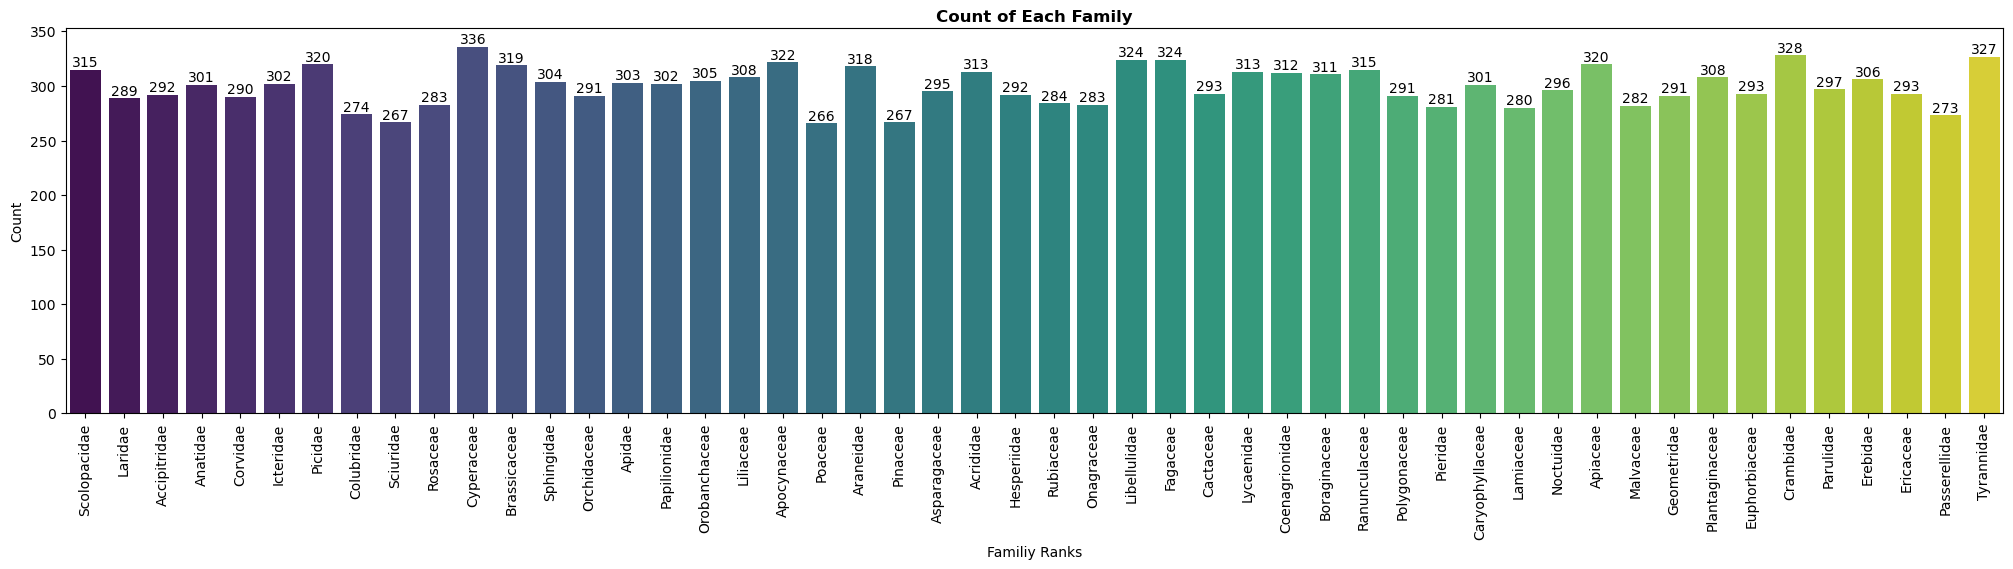

In [10]:
# adjusting the plot size
fig, ax = plt.subplots(figsize=(25,5))

# creating the plot
ax = sns.countplot(x = y_train_fine, palette = 'viridis')

# setting the value of the x-axis
ax.set_xticklabels(fine_names, rotation = 90)

# setting labels and title
ax.set_title('Count of Each Family', pad = 5, fontweight = 'bold')
ax.set(xlabel = 'Familiy Ranks', ylabel = 'Count')

# showing the count
ax.bar_label(ax.containers[0])

# showing the plot
plt.show()

Unlike the coarse grained labels, the labels for fine grained can be observed to be distributed relatively fair.

## 1.4 Creating the Datasets for Conventional Machine Learning

### 1.4.1 Datasets for fine

In [11]:
train_dl_coarse = create_dataset_tf('train', fine_grained = False, batch_size = 64)
val_dl_coarse = create_dataset_tf('val', fine_grained = False, batch_size = 64)
test_dl_coarse = create_dataset_tf('test', fine_grained = False, batch_size = 64)

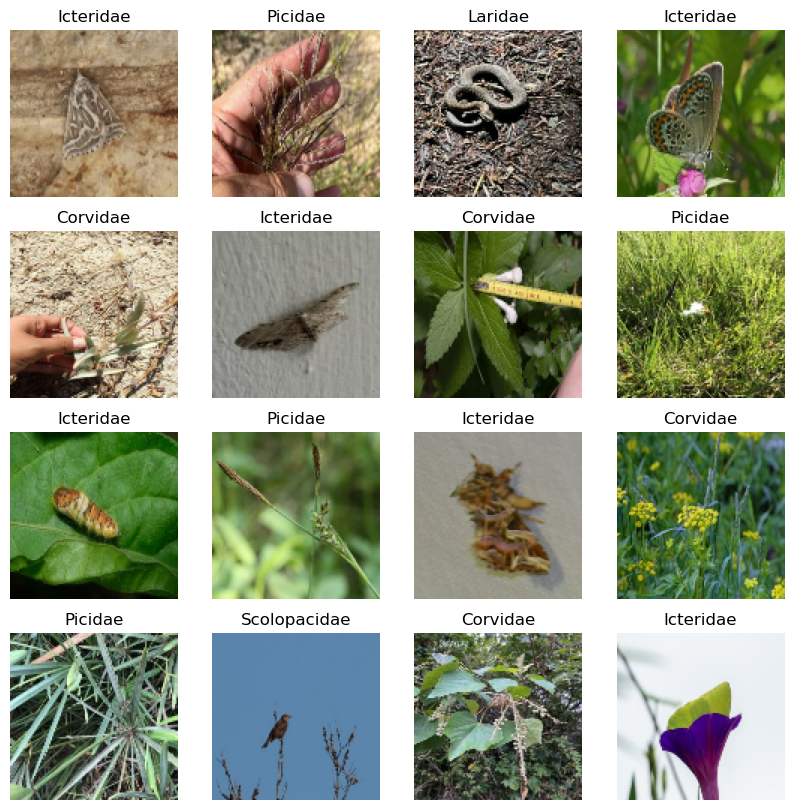

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_dl_coarse.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if True:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

### 1.4.2 Datasets for fine

In [13]:
train_dl_fine = create_dataset_tf('train', fine_grained = True, batch_size = 64)
val_dl_fine = create_dataset_tf('val', fine_grained = True, batch_size = 64)
test_dl_fine = create_dataset_tf('test', fine_grained = True, batch_size = 64)

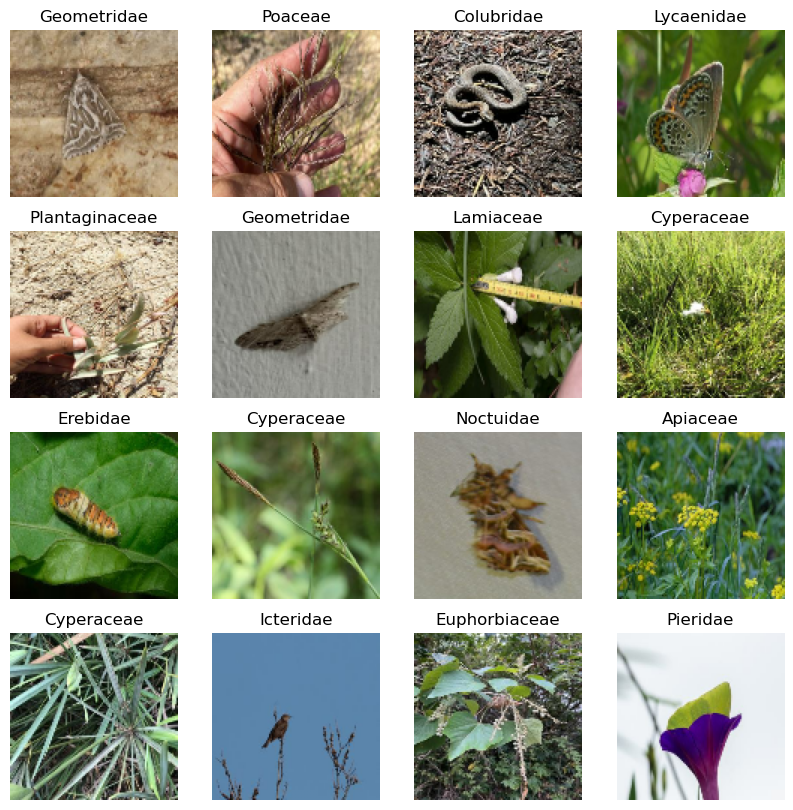

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_dl_fine.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if False:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(fine_names[labels[i]])
    plt.axis("off")
plt.show();

# 2. Conventional Machine Learning Models

For image classification tasks, there are several conventional machine learning models that are particularly useful, which are `SVM`, `Random Forests`, or `K-NN`.

## 2.1 Support Vector Machine Classifier

We will first start off with Support Vector Machine Classifier. Support Vector Machines (`SVM`) are good for image classification because they can handle high-dimensional data efficiently, find optimal decision boundaries, and effectively deal with non-linear relationships through the use of kernel functions, making them capable of capturing complex patterns and achieving high classification accuracy.

### 2.1.1 Model for coarse

#### 2.1.1.1 Preprocessing the images

We will be normalising the feature values to ensure that our features are in a consistent and comparable range, which can improve the performance and stability of the SVM classifier when working with image data.

In [15]:
# Preprocessing the images
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_coarse)
X_val_scaled = scaler.transform(X_val_coarse)
X_test_scaled = scaler.transform(X_test_coarse)

#### 2.1.1.2 Setting up the SVM classifier

The initial hyperparameters being set up will be as such:

 - Kernel = `rbf`: Radial basis function kernel should effectively model non-linear decision boundaries. It should allow the `SVM` to capture complex relationships between the features and the class labels.
 - C = 1.0: A smaller value of C allows for a wider margin but may result in more training errors, while a larger value of C allows for fewer training errors but may lead to a narrower margin. Setting C=1.0 in this case means that the `SVM` aims for a balanced trade-off between the training error and the margin size.
 - gamma = 'scale': The gamma value is automatically calculated as 1 / (n_features * X.var()). The 'scale' option scales the gamma value based on the number of features, which can help adapt the SVM to different datasets with varying numbers of features.
 
These hyperparameters can be fine tuned later on.

1. Creating the SVM classifier,

In [16]:
# Creating an SVM classifier
svm_classifier_c1 = SVC(kernel='rbf', C=1.0, gamma='scale')

2. Training the SVM classifier,

In [17]:
# Training the SVM classifier
svm_classifier_c1.fit(X_train_scaled, y_train_coarse)

SVC()

3. Evaluating the SVM classifier,

In [18]:
# Predicting the training and validation data
y_train_pred_svm_c1 = svm_classifier_c1.predict(X_train_scaled)
y_val_pred_svm_c1 = svm_classifier_c1.predict(X_val_scaled)

# Calculating accuracy on the training and validation set
train_accuracy_svm_c1 = accuracy_score(y_train_coarse, y_train_pred_svm_c1)
val_accuracy_svm_c1 = accuracy_score(y_val_coarse, y_val_pred_svm_c1)

# Calculating F1 score on the validation set
train_f1_svm_c1 = f1_score(y_train_coarse, y_train_pred_svm_c1, average='weighted')
val_f1_svm_c1 = f1_score(y_val_coarse, y_val_pred_svm_c1, average='weighted')

print(f"Training Accuracy: {train_accuracy_svm_c1}")
print(f"Validation Accuracy: {val_accuracy_svm_c1}\n")
print(f"Training F1 Score: {train_f1_svm_c1}")
print(f"Validation F1 Score: {val_f1_svm_c1}")

Training Accuracy: 0.6456666666666667
Validation Accuracy: 0.46838

Training F1 Score: 0.5868310296604383
Validation F1 Score: 0.4017103168828156


Based on the result above, the following can be observed,

 - **Accuracy**: The training accuracy is 0.6457, which indicates that the model is able to classify approximately 64.6% of the training samples correctly. The validation accuracy is lower at 0.4684, suggesting that the model's performance on unseen data is worse compared to the training set. The difference between the training and validation accuracies indicates that the model may be overfitting to the training data, meaning it is capturing the specific patterns and noise in the training set rather than generalizing well to new, unseen data.
 - **F1 Score**: The training F1 score is 0.5868, which provides a measure of the model's overall performance by considering both precision and recall. The validation F1 score is slightly lower at 0.4017. The F1 score takes into account the trade-off between precision (the ability to correctly identify positive samples) and recall (the ability to correctly identify all positive samples). The lower F1 score on the validation set suggests that the model's performance is poorer when generalizing to unseen data.

#### 2.1.1.3 Addressing the class imbalance

The result is not relatively high, this could be due to the existence of class imbalance. We will try addressing this issue

1. Calculating the class weights

In [19]:
# Calculating class weights
class_weights_c = class_weight.compute_class_weight(class_weight = 'balanced',
                                                    classes = np.unique(y_train_coarse),
                                                    y = y_train_coarse)

class_weights_c = dict(zip(np.unique(y_train_coarse), class_weights_c))
class_weights_c

{0: 0.6237524950099801,
 1: 6.843065693430657,
 2: 7.022471910112359,
 3: 5.89622641509434,
 4: 0.3467727020528944,
 5: 0.4728877679697352,
 6: 1.2533422459893049,
 7: 7.022471910112359}

2. Creating the SVM classifier,

In [20]:
# Creating an SVM classifier with class weighting
svm_classifier_c2 = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=class_weights_c)

3. Training the SVM classifier,

In [21]:
# Training the SVM classifier
svm_classifier_c2.fit(X_train_scaled, y_train_coarse)

SVC(class_weight={0: 0.6237524950099801, 1: 6.843065693430657,
                  2: 7.022471910112359, 3: 5.89622641509434,
                  4: 0.3467727020528944, 5: 0.4728877679697352,
                  6: 1.2533422459893049, 7: 7.022471910112359})

4. Evaluating the SVM classifier,

In [22]:
# Predicting the training and validation data
y_train_pred_svm_c2 = svm_classifier_c2.predict(X_train_scaled)
y_val_pred_svm_c2 = svm_classifier_c2.predict(X_val_scaled)

# Calculating accuracy on the training and validation set
train_accuracy_svm_c2 = accuracy_score(y_train_coarse, y_train_pred_svm_c2)
val_accuracy_svm_c2 = accuracy_score(y_val_coarse, y_val_pred_svm_c2)

# Calculating F1 score on the validation set
train_f1_svm_c2 = f1_score(y_train_coarse, y_train_pred_svm_c2, average='weighted')
val_f1_svm_c2 = f1_score(y_val_coarse, y_val_pred_svm_c2, average='weighted')

print(f"Training Accuracy: {train_accuracy_svm_c2}")
print(f"Validation Accuracy: {val_accuracy_svm_c2}\n")
print(f"Training F1 Score: {train_f1_svm_c2}")
print(f"Validation F1 Score: {val_f1_svm_c2}")

Training Accuracy: 0.6680666666666667
Validation Accuracy: 0.39538

Training F1 Score: 0.6644538629300052
Validation F1 Score: 0.38839145151157733


Based on the results above it can be observed that the model is performing even worse on the validation set:

 1. **Accuracy Change**: After computing the class weights, the training accuracy has slightly increased from 0.6457 to 0.6681, while the validation accuracy has decreased from 0.4684 to 0.3954. The increase in training accuracy suggests that the SVM model is now giving more importance to the minority class (which typically has a lower accuracy due to class imbalance). However, the decrease in validation accuracy might indicate that the model is becoming overfit to the training data and not generalizing well to unseen data. It is possible that the class weighting is causing the model to focus too much on the minority class and potentially misclassify some majority class samples in the validation set.

 2. **F1 Score Change**: The training F1 score has increased from 0.5868 to 0.6645, while the validation F1 score has slightly decreased from 0.4017 to 0.3884. The increase in training F1 score suggests that the SVM model is now better at capturing the predictive patterns of both the majority and minority classes, leading to improved performance on the training set. However, the slight decrease in validation F1 score indicates that the model's ability to generalize to the validation set has slightly diminished. This is consistent with the observation from the accuracy change.

### 2.1.2 Model for fine

#### 2.1.2.1 Preprocessing the images

We will be normalising the feature values to ensure that our features are in a consistent and comparable range, which can improve the performance and stability of the SVM classifier when working with image data.

In [23]:
# Preprocessing the images
scaler = StandardScaler()
X_train_scaled_f = scaler.fit_transform(X_train_fine)
X_val_scaled_f = scaler.transform(X_val_fine)
X_test_scaled_f = scaler.transform(X_test_fine)

#### 2.1.2.2 Setting up the SVM classifier

The initial hyperparameters being set up will be as such:

 - Kernel = `rbf`: Radial basis function kernel should effectively model non-linear decision boundaries. It should allow the `SVM` to capture complex relationships between the features and the class labels.
 - C = 1.0: A smaller value of C allows for a wider margin but may result in more training errors, while a larger value of C allows for fewer training errors but may lead to a narrower margin. Setting C=1.0 in this case means that the `SVM` aims for a balanced trade-off between the training error and the margin size.
 - gamma = 'scale': The gamma value is automatically calculated as 1 / (n_features * X.var()). The 'scale' option scales the gamma value based on the number of features, which can help adapt the SVM to different datasets with varying numbers of features.
 
These hyperparameters can be fine tuned later on.

1. Creating the SVM classifier,

In [24]:
# Creating an SVM classifier
svm_classifier_f1 = SVC(kernel='rbf', C=1.0, gamma='scale')

2. Training the SVM classifier,

In [25]:
# Training the SVM classifier
svm_classifier_f1.fit(X_train_scaled_f, y_train_coarse)

SVC()

3. Evaluating the SVM classifier,

In [26]:
# Predicting the training and validation data
y_train_pred_svm_f1 = svm_classifier_f1.predict(X_train_scaled_f)
y_val_pred_svm_f1 = svm_classifier_f1.predict(X_val_scaled_f)

# Calculating accuracy on the training and validation set
train_accuracy_svm_f1 = accuracy_score(y_train_fine, y_train_pred_svm_f1)
val_accuracy_svm_f1 = accuracy_score(y_val_fine, y_val_pred_svm_f1)

# Calculating F1 score on the validation set
train_f1_svm_f1 = f1_score(y_train_coarse, y_train_pred_svm_f1, average='weighted')
val_f1_svm_f1 = f1_score(y_val_coarse, y_val_pred_svm_f1, average='weighted')

print(f"Training Accuracy: {train_accuracy_svm_f1}")
print(f"Validation Accuracy: {val_accuracy_svm_f1}\n")
print(f"Training F1 Score: {train_f1_svm_f1}")
print(f"Validation F1 Score: {val_f1_svm_f1}")

Training Accuracy: 0.021266666666666666
Validation Accuracy: 0.0238

Training F1 Score: 0.5868310296604383
Validation F1 Score: 0.4017103168828156


Based on the result above, the following can be observed,

 - **Accuracy**: The training accuracy is 0.6457, which indicates that the model is able to classify approximately 64.6% of the training samples correctly. The validation accuracy is lower at 0.4684, suggesting that the model's performance on unseen data is worse compared to the training set. The difference between the training and validation accuracies indicates that the model may be overfitting to the training data, meaning it is capturing the specific patterns and noise in the training set rather than generalizing well to new, unseen data.
 - **F1 Score**: The training F1 score is 0.5868, which provides a measure of the model's overall performance by considering both precision and recall. The validation F1 score is slightly lower at 0.4017. The F1 score takes into account the trade-off between precision (the ability to correctly identify positive samples) and recall (the ability to correctly identify all positive samples). The lower F1 score on the validation set suggests that the model's performance is poorer when generalizing to unseen data.

### 2.1.3 Summary

In [27]:
summary_svm = pd.DataFrame({
    "Data": ["Coarse", "Coarse", "Fine"],
    "Model": ["SVC", "SVC w/ weight", "SVC"],
    "Training Accuracy": [train_accuracy_svm_c1, train_accuracy_svm_c2, train_accuracy_svm_f1],
    "Validation Accuracy": [val_accuracy_svm_c1, val_accuracy_svm_c2, val_accuracy_svm_f1],
    "Training F1 Score": [train_f1_svm_c1, train_f1_svm_c2, train_f1_svm_f1],
    "Validation F1 Score": [val_f1_svm_c1, val_f1_svm_c2, val_f1_svm_f1],    
})
summary_svm

,Data,Model,Training Accuracy,Validation Accuracy,Training F1 Score,Validation F1 Score
0,Coarse,SVC,0.645667,0.46838,0.586831,0.401710
1,Coarse,SVC w/ weight,0.668067,0.39538,0.664454,0.388391
2,Fine,SVC,0.021267,0.02380,0.586831,0.401710


This suggests that the SVC model fails to generalize well to unseen data, particularly given the increased complexity of the fine-grained classification with 50 labels. The model's inability to effectively capture the intricate patterns and distinctions among the fine categories highlights the need for further improvements and exploration of alternative approaches to enhance performance on this challenging task.

We could try using ensemble methods like `BaggingClassifier` or `AdaBoostClassifier`, or increasing the training data, but it does not appear that the model will perform much better.  

We will try `RandomForest` next.

## 2.2 Random Forest Classifier

Random Forest is well-suited for image classification because it can effectively handle high-dimensional data, capture complex interactions between features, handle class imbalances, and provide robust predictions. It combines multiple decision trees to form an ensemble, resulting in improved accuracy and robustness for image classification tasks.

### 2.2.1 Model for coarse

Unlike `SVM`, feature scaling is not required for `Random Forest` (RF) because RF algorithms are not sensitive to the scale of the input features. `Random Forest` builds decision trees based on feature thresholds and does not rely on distance-based calculations. Therefore, we can omit feature scaling when using Random Forest for image classification.

#### 2.2.1.1 Setting up the RF classifier

1. Creating the Random Forest Classifier

In [28]:
# Creating a Random Forest classifier
rf_classifier_c1 = RandomForestClassifier(n_estimators=100, n_jobs = -1, random_state=2215)

2. Training the Random Forest Classifier

In [29]:
# Fitting the classifier on the training data
rf_classifier_c1.fit(X_train_coarse, y_train_coarse)

RandomForestClassifier(n_jobs=-1, random_state=2215)

3. Evaluating the Random Forest Classifier

In [30]:
# Predicting on the training and validation data
y_train_pred_rf_c1 = rf_classifier_c1.predict(X_train_coarse)
y_val_pred_rf_c1 = rf_classifier_c1.predict(X_val_coarse)

# Calculating accuracy and F1 score
train_accuracy_rf_c1 = accuracy_score(y_train_coarse, y_train_pred_rf_c1)
val_accuracy_rf_c1 = accuracy_score(y_val_coarse, y_val_pred_rf_c1)

train_f1_score_rf_c1 = f1_score(y_train_coarse, y_train_pred_rf_c1, average='weighted')
val_f1_score_rf_c1 = f1_score(y_val_coarse, y_val_pred_rf_c1, average='weighted')

# Printing the results
print(f"Training Accuracy: {train_accuracy_rf_c1}")
print(f"Validation Accuracy: {val_accuracy_rf_c1}\n")
print(f"Training F1 Score: {train_f1_score_rf_c1}")
print(f"Validation F1 Score: {val_f1_score_rf_c1}")

Training Accuracy: 1.0
Validation Accuracy: 0.47468

Training F1 Score: 1.0
Validation F1 Score: 0.40682954119921616


#### 2.2.1.2 Hyperparameter tuning

1. Creating the Random Forest Classifier

In [31]:
# Creating a Random Forest classifier
rf_classifier_c2 = RandomForestClassifier(n_estimators=100, n_jobs = -1, random_state=2215)

2. Setting up the `GridSearchCV` for hyperparameter tuning

In [32]:
# Hyperparameter tuning using GridSearchCV
param_grid_c2 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search_c2 = GridSearchCV(estimator=rf_classifier_c2, param_grid=param_grid_c2, scoring='accuracy', cv=5)
grid_search_c2.fit(X_train_coarse, y_train_coarse)
best_rf_classifier_c2 = grid_search_c2.best_estimator_
best_rf_classifier_c2

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=2215)

In [33]:
print(grid_search_c2.best_params_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


3. Training the Best RF classifier

In [34]:
best_rf_classifier_c2.fit(X_train_coarse, y_train_coarse)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=2215)

4. Evaluating the Best RF classifier

In [35]:
# Predicting on the training and validation data
y_train_pred_rf_c2 = best_rf_classifier_c2.predict(X_train_coarse)
y_val_pred_rf_c2 = best_rf_classifier_c2.predict(X_val_coarse)

# Calculating accuracy and F1 score
train_accuracy_rf_c2 = accuracy_score(y_train_coarse, y_train_pred_rf_c2)
val_accuracy_rf_c2 = accuracy_score(y_val_coarse, y_val_pred_rf_c2)

train_f1_score_rf_c2 = f1_score(y_train_coarse, y_train_pred_rf_c2, average='weighted')
val_f1_score_rf_c2 = f1_score(y_val_coarse, y_val_pred_rf_c2, average='weighted')

# Printing the results
print(f"Training Accuracy: {train_accuracy_rf_c2}")
print(f"Validation Accuracy: {val_accuracy_rf_c2}\n")
print(f"Training F1 Score: {train_f1_score_rf_c2}")
print(f"Validation F1 Score: {val_f1_score_rf_c2}")

Training Accuracy: 1.0
Validation Accuracy: 0.4801

Training F1 Score: 1.0
Validation F1 Score: 0.4099469816335301


### 2.2.2 Model for fine

Unlike `SVM`, feature scaling is not required for `Random Forest` (RF) because RF algorithms are not sensitive to the scale of the input features. `Random Forest` builds decision trees based on feature thresholds and does not rely on distance-based calculations. Therefore, we can omit feature scaling when using Random Forest for image classification.

#### 2.2.2.1 Setting up the RF classifier

1. Creating the Random Forest Classifier

In [36]:
# Creating a Random Forest classifier
rf_classifier_f1 = RandomForestClassifier(max_depth = None,
                                          min_samples_split = 2,
                                          n_estimators = 100,
                                          n_jobs = -1,
                                          random_state = 2215)

2. Training the Random Forest Classifier

In [37]:
# Fitting the classifier on the training data
rf_classifier_f1.fit(X_train_fine, y_train_fine)

RandomForestClassifier(n_jobs=-1, random_state=2215)

3. Evaluating the Random Forest Classifier

In [38]:
# Predicting on the training and validation data
y_train_pred_rf_f1 = rf_classifier_f1.predict(X_train_fine)
y_val_pred_rf_f1 = rf_classifier_f1.predict(X_val_fine)

# Calculating accuracy and F1 score
train_accuracy_rf_f1 = accuracy_score(y_train_fine, y_train_pred_rf_f1)
val_accuracy_rf_f1 = accuracy_score(y_val_fine, y_val_pred_rf_f1)

train_f1_score_rf_f1 = f1_score(y_train_fine, y_train_pred_rf_f1, average='weighted')
val_f1_score_rf_f1 = f1_score(y_val_fine, y_val_pred_rf_f1, average='weighted')

# Printing the results
print(f"Training Accuracy: {train_accuracy_rf_f1}")
print(f"Validation Accuracy: {val_accuracy_rf_f1}\n")
print(f"Training F1 Score: {train_f1_score_rf_f1}")
print(f"Validation F1 Score: {val_f1_score_rf_f1}")

Training Accuracy: 1.0
Validation Accuracy: 0.05756

Training F1 Score: 1.0
Validation F1 Score: 0.05230239183031309


### 2.2.3 Summary

In [39]:
summary_rf = pd.DataFrame({
    "Data": ["Coarse", "Coarse", "Fine"],
    "Model": ["RF", "RF - Fine Tuned", "RF"],
    "Training Accuracy": [train_accuracy_rf_c1, train_accuracy_rf_c2, train_accuracy_rf_f1],
    "Validation Accuracy": [val_accuracy_rf_c1, val_accuracy_rf_c2, val_accuracy_rf_f1],
    "Training F1 Score": [train_f1_score_rf_c1, train_f1_score_rf_c2, train_f1_score_rf_f1],
    "Validation F1 Score": [val_f1_score_rf_c1, val_f1_score_rf_c2, val_f1_score_rf_f1],    
})
summary_rf

,Data,Model,Training Accuracy,Validation Accuracy,Training F1 Score,Validation F1 Score
0,Coarse,RF,1.0,0.47468,1.0,0.406830
1,Coarse,RF - Fine Tuned,1.0,0.48010,1.0,0.409947
2,Fine,RF,1.0,0.05756,1.0,0.052302


The `Random Forest` models exhibit perfect training accuracy and F1 scores, indicating their ability to memorize the training data. However, they struggle to generalize well to unseen examples, as evidenced by lower validation accuracy and F1 scores. This suggests overfitting, where the models fail to capture the underlying patterns in the data. To address this, techniques like regularization, feature selection, or hyperparameter tuning can be applied to improve generalization and enhance model performance on unseen data.

## 2.3 Blending

Since we have already trained using two models, `SVC` and `Random Forest`, we will now try to use `Blending`. `Blending` is an ensemble technique where predictions from multiple models are combined using another model (meta-model) to make the final prediction. It leverages the strengths of diverse models and can improve overall performance by learning to blend their predictions effectively.

### 2.3.1 Model for coarse

1. Creating the meta-model,

In [40]:
# Creating the meta-model
meta_model_c = SVC(kernel='rbf', C=1, gamma='scale')

2. Combining the prediction results of `SVC` and `Random Forest`,

In [41]:
# Using the predictions of the base models as features
X_train_meta_c = np.column_stack((y_train_pred_svm_c1, y_train_pred_rf_c2))
X_val_meta_c = np.column_stack((y_val_pred_svm_c1, y_val_pred_rf_c2))

3. Training the meta-model,

In [42]:
meta_model_c.fit(X_train_meta_c, y_train_coarse)

SVC(C=1)

4. Evaluating the meta-model,

In [43]:
# Predicting on the training and validation data
y_train_pred_b_c = meta_model_c.predict(X_train_meta_c)
y_val_pred_b_c = meta_model_c.predict(X_val_meta_c)

# Calculating accuracy and F1 score
train_accuracy_b_c = accuracy_score(y_train_coarse, y_train_pred_b_c)
val_accuracy_b_c = accuracy_score(y_val_coarse, y_val_pred_b_c)
train_f1_score_b_c = f1_score(y_train_coarse, y_train_pred_b_c, average='weighted')
val_f1_score_b_c = f1_score(y_val_coarse, y_val_pred_b_c, average='weighted')

# Printing the results
print(f"Training Accuracy: {train_accuracy_b_c}")
print(f"Validation Accuracy: {val_accuracy_b_c}\n")
print(f"Training F1 Score: {train_f1_score_b_c}")
print(f"Validation F1 Score: {val_f1_score_b_c}")

Training Accuracy: 1.0
Validation Accuracy: 0.4801

Training F1 Score: 1.0
Validation F1 Score: 0.4099469816335301


### 2.3.2 Model for fine

1. Creating the meta-model,

In [44]:
# Creating the meta-model
meta_model_f = SVC(kernel='rbf', C=1, gamma='scale')

2. Combining the prediction results of `SVC` and `Random Forest`,

In [45]:
# Using the predictions of the base models as features
X_train_meta_f = np.column_stack((y_train_pred_svm_f1, y_train_pred_rf_f1))
X_val_meta_f = np.column_stack((y_val_pred_svm_f1, y_val_pred_rf_f1))

3. Training the meta-model,

In [46]:
meta_model_f.fit(X_train_meta_f, y_train_fine)

SVC(C=1)

4. Evaluating the meta-model,

In [47]:
# Predicting on the training and validation data
y_train_pred_b_f = meta_model_c.predict(X_train_meta_c)
y_val_pred_b_f = meta_model_c.predict(X_val_meta_c)

# Calculating accuracy and F1 score
train_accuracy_b_f = accuracy_score(y_train_fine, y_train_pred_b_f)
val_accuracy_b_f = accuracy_score(y_val_fine, y_val_pred_b_f)
train_f1_score_b_f = f1_score(y_train_fine, y_train_pred_b_f, average='weighted')
val_f1_score_b_f = f1_score(y_val_fine, y_val_pred_b_f, average='weighted')

# Printing the results
print(f"Training Accuracy: {train_accuracy_b_f}")
print(f"Validation Accuracy: {val_accuracy_b_f}\n")
print(f"Training F1 Score: {train_f1_score_b_f}")
print(f"Validation F1 Score: {val_f1_score_b_f}")

Training Accuracy: 0.021
Validation Accuracy: 0.02228

Training F1 Score: 0.003983739837398374
Validation F1 Score: 0.004048014105850648


### 2.3.3 Summary

In [48]:
summary_b = pd.DataFrame({
    "Data": ["Coarse", "Fine"],
    "Model": ["Blending", "Blending"],
    "Training Accuracy": [train_accuracy_b_c, train_accuracy_b_f],
    "Validation Accuracy": [val_accuracy_b_c, val_accuracy_b_f],
    "Training F1 Score": [train_f1_score_b_c, train_f1_score_b_f],
    "Validation F1 Score": [val_f1_score_b_c, val_f1_score_b_f],    
})
summary_b

,Data,Model,Training Accuracy,Validation Accuracy,Training F1 Score,Validation F1 Score
0,Coarse,Blending,1.000,0.48010,1.000000,0.409947
1,Fine,Blending,0.021,0.02228,0.003984,0.004048


The blending approach was applied to improve the performance of the base models. However, the blending predictions for Coarse is equal to one of the base model predictions, `Random Forest`, it suggests that the blending algorithm may not be effectively leveraging the diversity of the base models and further adjustments may be needed in the blending process. It is worth noting that the blending approach did not yield any improvements for the Fine classification task, which could be due to the base models not generalising well to fine-grained labels. Further exploration and refinement of the base models and blending technique may be required to enhance performance in the Fine classification task.

## 2.4 Predicting the public test set

Below is the summary of all the models we have performed,

In [49]:
conv_summary = []
conv_summary = pd.concat([summary_svm, summary_rf, summary_b])
conv_summary.sort_values('Data')

,Data,Model,Training Accuracy,Validation Accuracy,Training F1 Score,Validation F1 Score
0,Coarse,SVC,0.645667,0.46838,0.586831,0.401710
1,Coarse,SVC w/ weight,0.668067,0.39538,0.664454,0.388391
0,Coarse,RF,1.000000,0.47468,1.000000,0.406830
1,Coarse,RF - Fine Tuned,1.000000,0.48010,1.000000,0.409947
0,Coarse,Blending,1.000000,0.48010,1.000000,0.409947
2,Fine,SVC,0.021267,0.02380,0.586831,0.401710
2,Fine,RF,1.000000,0.05756,1.000000,0.052302
1,Fine,Blending,0.021000,0.02228,0.003984,0.004048


It can be observed that for both Coarse and Fine, fine tuned `Random Forest` appears to have the highest validation accuracy. Since either SVC or RF have a similar validation accuracy, we will try to use both models to predict the test set.

### 2.4.1 Support Vector Machine Classifier

We will now try to predict the public test data for coarse.

In [50]:
y_pred_svm_c1 = svm_classifier_c1.predict(X_test_scaled)

In [51]:
# saving it into a csv format
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred_svm_c1
test_csv = test_csv.drop(columns=['fine'])
pred_file = "47446730-conv-C01.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 46.906%.

We will now try to predict the public test data for fine.

In [52]:
y_pred_svm_f1 = svm_classifier_f1.predict(X_test_scaled_f)

In [53]:
# saving it into a csv format
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = y_pred_svm_f1
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "47446730-conv-F01.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 2.48%.

### 2.4.1 Support Vector Machine Classifier

We will now try to predict the public test data for coarse.

In [54]:
y_pred_rf_c1 = best_rf_classifier_c2.predict(X_test_coarse)

In [55]:
# saving it into a csv format
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred_rf_c1
test_csv = test_csv.drop(columns=['fine'])
pred_file = "47446730-conv-C02.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 47.91% which is better than the `SVC` model.

We will now try to predict the public test data for fine.

In [56]:
y_pred_rf_f1 = rf_classifier_f1.predict(X_test_fine)

In [57]:
# saving it into a csv format
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = y_pred_rf_f1
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "47446730-conv-F02.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 5.732%.

## 2.5 Summary for Conventional Machine Learning

#### Discussion on the models

We have trained several conventional machine learning models:
1. Support Vector Machine,
2. Random Forest, and
3. Blending.

The rationale behind choosing this 3 models is simple. For image classification, SVM, RF, and KNN are the most popular models, but SVM and RF are way better than KNN due to the type of images, i.e., with lots of noise. For:
1. Support Vector Machine: The hyperparameters chosen are the defaults, and we would like to know how it well it performs using the default. Since the results are not that satisfactory, we have decided not to tune its hyperparameters as it won't be improving by much. We have tried to address the class imbalance as well for the coarse model, but it just made the model overfit the minor classes and decreases the model overall performance.
2. Random Forest: The hyperparameters chosen are the defaults as well, but for this model we tried to fine-tuned the hyperparameters. Just like what we had suspected, if the model did not perform well initially, fine tuning it will not affect the performance a lot, which can be seen from the result improving slightly.
3. Blending: As we already have the predictions from two models, we will not waste this opportunity and would like to apply this ensemble technique. It basically takes the predictions from the two models, and used another model to predict the labels based on these input. However, it appears that the weights from the RF model is too big that the result of the blending is exactly the same as it is.

#### Discussion on the results

In [58]:
summary_conv = pd.DataFrame({
    "Data": ["Coarse", "Coarse", "Fine", "Fine"],
    "Model": ["SVC", "RF - Fine Tuned", "SVC", "RF"],
    "Training Accuracy": [train_accuracy_svm_c1, train_accuracy_rf_c2, train_accuracy_svm_f1, train_accuracy_rf_f1],
    "Validation Accuracy": [val_accuracy_svm_c1, val_accuracy_rf_c2, val_accuracy_svm_f1, val_accuracy_rf_f1],
    "Test Accuracy": [0.46906, 0.4791, 0.0248, 0.05732]
})
summary_conv

,Data,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,Coarse,SVC,0.645667,0.46838,0.46906
1,Coarse,RF - Fine Tuned,1.000000,0.48010,0.47910
2,Fine,SVC,0.021267,0.02380,0.02480
3,Fine,RF,1.000000,0.05756,0.05732


Based on the obtained results, it can be inferred that both the SVC and RF models show limited reliability for image classification tasks. Despite potential avenues for improvement, such as increasing the training data or fine-tuning the models, the initial outcomes indicate that significant enhancements may be challenging to achieve. Consequently, it is better to explore alternative approaches, such as training deep learning models, in order to leverage their inherent capabilities for more effective image classification.

# 3. Deep Learning Models

Deep learning is highly effective for image classification due to its ability to automatically learn intricate patterns and features directly from raw image data. Unlike conventional machine learning algorithms that rely on handcrafted features, deep learning models can automatically extract hierarchical representations from images, capturing both low-level features (e.g., edges, textures) and high-level semantic information (e.g., shapes, objects). With their deep neural architectures and millions of trainable parameters, deep learning models can leverage this learned knowledge to achieve state-of-the-art performance in image classification tasks, making them ideal for handling complex visual data with large-scale datasets.

## 3.1 Simple CNN Architecture

### 3.1.1 Model for coarse

#### First attempt:

Defining the model,

In [59]:
# Defining the model architecture
model_c_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(112, 112, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(8, activation="softmax")
])

Compiling the model,

In [60]:
# Compiling the model
model_c_1.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

Training the model,

In [61]:
# Define the filepath for saving the best model
checkpoint_path = 'deep_c_01.h5'

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          mode='max',
                                          verbose=1)

In [62]:
# Train the model
history_c_1 = model_c_1.fit(train_dl_coarse,
                            validation_data=val_dl_coarse,
                            callbacks=[model_checkpoint],
                            epochs=10)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 1.2916 - accuracy: 0.5554
Epoch 1: val_accuracy improved from -inf to 0.59326, saving model to deep_c_01.h5
1563/1563 [==============================] - 560s 357ms/step - loss: 1.2916 - accuracy: 0.5554 - val_loss: 1.1737 - val_accuracy: 0.5933
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 1.0541 - accuracy: 0.6259
Epoch 2: val_accuracy improved from 0.59326 to 0.59328, saving model to deep_c_01.h5
1563/1563 [==============================] - 577s 369ms/step - loss: 1.0541 - accuracy: 0.6259 - val_loss: 1.1977 - val_accuracy: 0.5933
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 0.8582 - accuracy: 0.6922
Epoch 3: val_accuracy did not improve from 0.59328
1563/1563 [==============================] - 540s 345ms/step - loss: 0.8582 - accuracy: 0.6922 - val_loss: 1.2806 - val_accuracy: 0.5778
Epoch 4/10
1563/1563 [==============================] - ETA: 0s - loss: 0.671

Analysing the model,

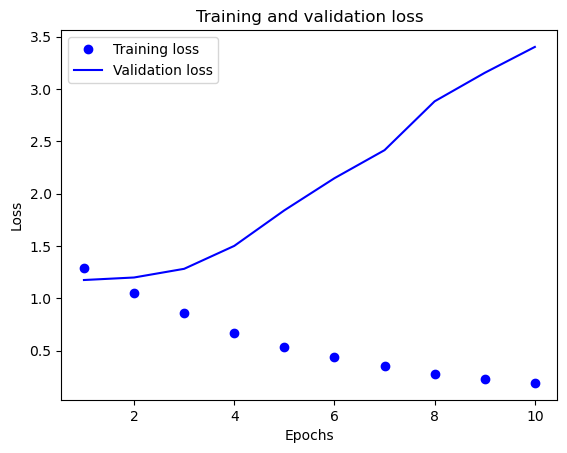

In [63]:
# Creating a function to plot graphs
def train_val_loss(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

history_dict = history_c_1.history
train_val_loss(history_dict)

It can be observed that after the $2^{nd}$ epoch, the model has started to overfit the training data. Let's try to apply `BatchNormalisation` and `Dropout` to the model.

#### Second attempt - Applying regularisation and normalisation:

Defining the model,

In [64]:
# Defining the model architecture
model_c_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(112, 112, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax")
])

Compiling the model,

In [65]:
# Compiling the model
model_c_2.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

Training the model,

In [66]:
# Define the filepath for saving the best model
checkpoint_path = 'deep_c_02.h5'

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [67]:
# Train the model
history_c_2 = model_c_2.fit(train_dl_coarse,
                            validation_data=val_dl_coarse,
                            callbacks=[model_checkpoint],
                            epochs=10)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 1.3994 - accuracy: 0.5312
Epoch 1: val_accuracy improved from -inf to 0.52376, saving model to deep_c_02.h5
1563/1563 [==============================] - 868s 554ms/step - loss: 1.3994 - accuracy: 0.5312 - val_loss: 1.3463 - val_accuracy: 0.5238
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 1.1580 - accuracy: 0.5947
Epoch 2: val_accuracy improved from 0.52376 to 0.56508, saving model to deep_c_02.h5
1563/1563 [==============================] - 864s 553ms/step - loss: 1.1580 - accuracy: 0.5947 - val_loss: 1.2052 - val_accuracy: 0.5651
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.6192
Epoch 3: val_accuracy improved from 0.56508 to 0.59786, saving model to deep_c_02.h5
1563/1563 [==============================] - 863s 552ms/step - loss: 1.0777 - accuracy: 0.6192 - val_loss: 1.1383 - val_accuracy: 0.5979
Epoch 4/10
1563/1563 [=====================

Analysing the model,

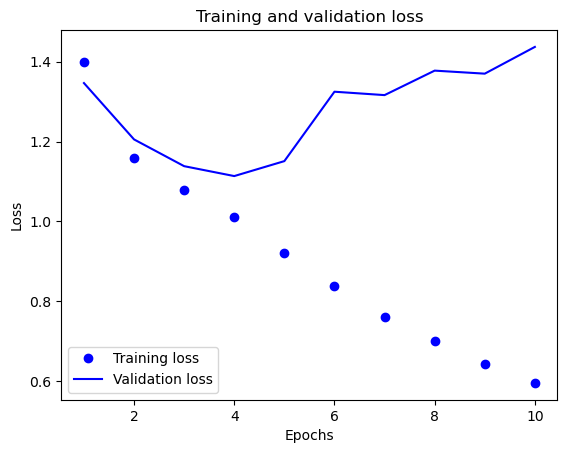

In [68]:
history_dict = history_c_2.history
train_val_loss(history_dict)

It can be observed that the overfitting did indeed become slightly better.

### 3.1.2 Model for fine

Since we know that the base model will most likely overfit the training data, we will immediately attempt to use `BatchNormalization` and `Dropout`.

Defining the model,

In [70]:
# Defining the model architecture
model_f_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(112, 112, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(50, activation="softmax")
])

Compiling the model,

In [71]:
# Compiling the model
model_f_1.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

Training the model,

In [72]:
# Define the filepath for saving the best model
checkpoint_path = 'deep_f_01.h5'

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [73]:
# Train the model
history_f_1 = model_f_1.fit(train_dl_fine,
                            validation_data=val_dl_fine,
                            callbacks=[model_checkpoint],
                            epochs=10)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 3.6320 - accuracy: 0.0828
Epoch 1: val_accuracy improved from -inf to 0.09982, saving model to deep_f_01.h5
1563/1563 [==============================] - 857s 548ms/step - loss: 3.6320 - accuracy: 0.0828 - val_loss: 3.4712 - val_accuracy: 0.0998
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 3.2553 - accuracy: 0.1372
Epoch 2: val_accuracy improved from 0.09982 to 0.11252, saving model to deep_f_01.h5
1563/1563 [==============================] - 895s 573ms/step - loss: 3.2553 - accuracy: 0.1372 - val_loss: 3.5755 - val_accuracy: 0.1125
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 3.0954 - accuracy: 0.1699
Epoch 3: val_accuracy improved from 0.11252 to 0.13238, saving model to deep_f_01.h5
1563/1563 [==============================] - 881s 564ms/step - loss: 3.0954 - accuracy: 0.1699 - val_loss: 3.3720 - val_accuracy: 0.1324
Epoch 4/10
1563/1563 [=====================

Analysing the model,

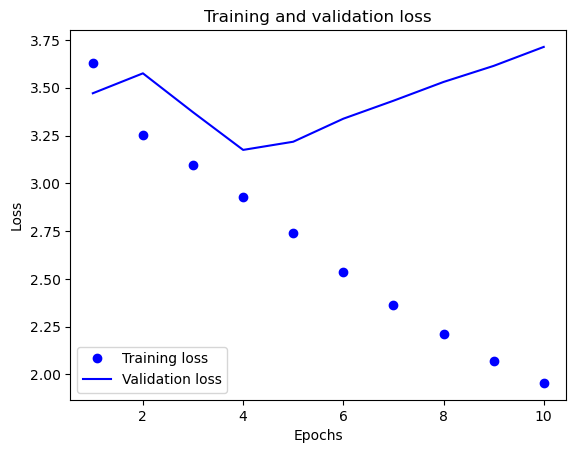

In [74]:
history_dict = history_f_1.history
train_val_loss(history_dict)

## 3.2 VGG16

### 3.2.1 Model for coarse

Though it is not recommended to decrease the training dataset, unless it is done, each epoch will take around 2 hours.

In [75]:
new_train_dl_coarse = train_dl_coarse.take(int(len(train_dl_coarse) * 0.3))
new_val_dl_coarse = val_dl_coarse.take(int(len(val_dl_coarse) * 0.3))

Loading the pre-trained model,

In [76]:
resnet50_c = ResNet50V2(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [77]:
vgg16_c = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

Freezing the pre-trained layers to prevent them from being trained,

In [78]:
for layer in resnet50_c.layers:
    layer.trainable = False

Defining the model,

In [79]:
# Defining the model architecture
model_c_3 = keras.models.Sequential([
    vgg16_c,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax")
])

Compiling the model,

In [80]:
# Compiling the model
model_c_3.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

Training the model,

In [81]:
# Define the filepath for saving the best model
checkpoint_path = 'deep_c_03.h5'

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [82]:
# Train the model
history_c_3 = model_c_3.fit(new_train_dl_coarse,
                            validation_data=new_val_dl_coarse,
                            callbacks=[model_checkpoint],
                            epochs=10)

Epoch 1/10
468/468 [==============================] - ETA: 0s - loss: 1.6075 - accuracy: 0.4596 
Epoch 1: val_accuracy improved from -inf to 0.29000, saving model to deep_c_03.h5
468/468 [==============================] - 6086s 13s/step - loss: 1.6075 - accuracy: 0.4596 - val_loss: 86.7653 - val_accuracy: 0.2900
Epoch 2/10
468/468 [==============================] - ETA: 0s - loss: 1.3688 - accuracy: 0.5271 
Epoch 2: val_accuracy improved from 0.29000 to 0.40171, saving model to deep_c_03.h5
468/468 [==============================] - 6018s 13s/step - loss: 1.3688 - accuracy: 0.5271 - val_loss: 2.5060 - val_accuracy: 0.4017
Epoch 3/10
468/468 [==============================] - ETA: 0s - loss: 1.2898 - accuracy: 0.5564 
Epoch 3: val_accuracy improved from 0.40171 to 0.50127, saving model to deep_c_03.h5
468/468 [==============================] - 6162s 13s/step - loss: 1.2898 - accuracy: 0.5564 - val_loss: 1.4167 - val_accuracy: 0.5013
Epoch 4/10
468/468 [==============================] - 

Analysing the model,

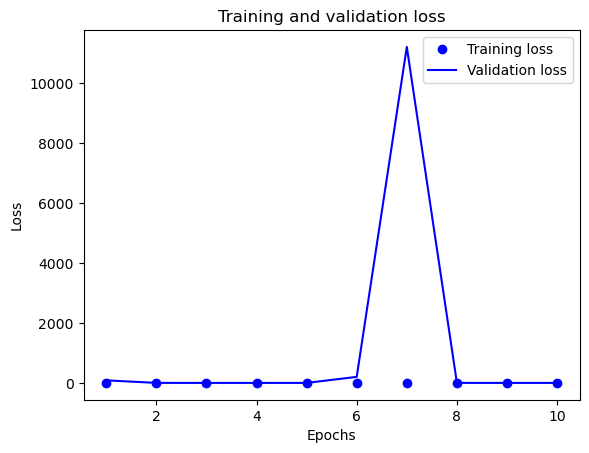

In [83]:
history_dict = history_c_3.history
train_val_loss(history_dict)

### 3.2.2 Model for fine

In [84]:
new_train_dl_fine = train_dl_fine.take(int(len(train_dl_fine) * 0.3))
new_val_dl_fine = val_dl_fine.take(int(len(val_dl_fine) * 0.3))

Loading the pre-trained model,

In [85]:
resnet50_f = ResNet50V2(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [86]:
vgg16_f = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

Freezing the pre-trained layers to prevent them from being trained,

In [87]:
for layer in resnet50_f.layers:
    layer.trainable = False

In [88]:
for layer in vgg16_f.layers:
    layer.trainable = False

Defining the model,

In [89]:
# Defining the model architecture
model_f_2 = keras.models.Sequential([
    vgg16_f,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(50, activation="softmax")
])

Compiling the model,

In [90]:
# Compiling the model
model_f_2.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

Training the model,

In [91]:
# Define the filepath for saving the best model
checkpoint_path = 'deep_f_02.h5'

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [92]:
# Train the model
history_f_2 = model_f_2.fit(new_train_dl_fine,
                            validation_data=new_val_dl_fine,
                            callbacks=[model_checkpoint],
                            epochs=10)

Epoch 1/10
468/468 [==============================] - ETA: 0s - loss: 3.5291 - accuracy: 0.1102
Epoch 1: val_accuracy improved from -inf to 0.18697, saving model to deep_f_02.h5
468/468 [==============================] - 2438s 5s/step - loss: 3.5291 - accuracy: 0.1102 - val_loss: 3.0918 - val_accuracy: 0.1870
Epoch 2/10
468/468 [==============================] - ETA: 0s - loss: 3.1002 - accuracy: 0.1774
Epoch 2: val_accuracy improved from 0.18697 to 0.20913, saving model to deep_f_02.h5
468/468 [==============================] - 2434s 5s/step - loss: 3.1002 - accuracy: 0.1774 - val_loss: 2.9530 - val_accuracy: 0.2091
Epoch 3/10
468/468 [==============================] - ETA: 0s - loss: 2.9546 - accuracy: 0.2059
Epoch 3: val_accuracy improved from 0.20913 to 0.21194, saving model to deep_f_02.h5
468/468 [==============================] - 2455s 5s/step - loss: 2.9546 - accuracy: 0.2059 - val_loss: 2.9136 - val_accuracy: 0.2119
Epoch 4/10
468/468 [==============================] - ETA: 0s

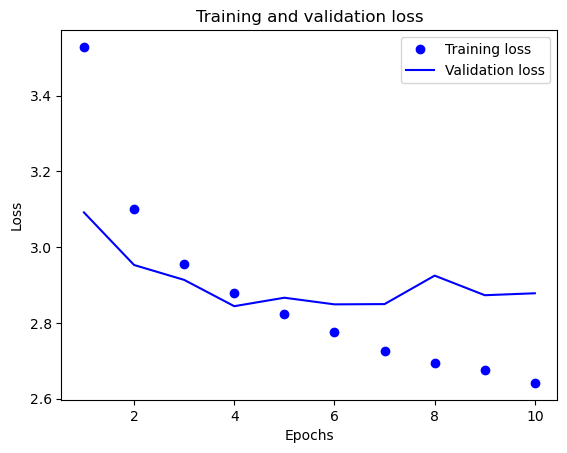

In [94]:
history_dict = history_f_2.history
train_val_loss(history_dict)

## 3.3 ResNet50V2

### 3.3.1 Model for coarse

Loading the pre-trained model,

In [95]:
resnet50_c = ResNet50V2(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

Freezing the pre-trained layers to prevent them from being trained,

In [96]:
for layer in resnet50_c.layers:
    layer.trainable = False

Defining the model,

In [97]:
# Defining the model architecture
model_c_4 = keras.models.Sequential([
    resnet50_c,
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),    
    keras.layers.Dense(8, activation="softmax")
])

Compiling the model,

In [98]:
# Compiling the model
model_c_4.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

Training the model,

In [99]:
# Define the filepath for saving the best model
checkpoint_path = 'deep_c_04.h5'

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [100]:
# Train the model
history_c_4 = model_c_4.fit(train_dl_coarse,
                            validation_data=val_dl_coarse,
                            callbacks=[model_checkpoint],
                            epochs=10)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 1.1506 - accuracy: 0.6301
Epoch 1: val_accuracy improved from -inf to 0.69932, saving model to deep_c_04.h5
1563/1563 [==============================] - 2972s 2s/step - loss: 1.1506 - accuracy: 0.6301 - val_loss: 0.8600 - val_accuracy: 0.6993
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 0.9230 - accuracy: 0.6911
Epoch 2: val_accuracy improved from 0.69932 to 0.71204, saving model to deep_c_04.h5
1563/1563 [==============================] - 3009s 2s/step - loss: 0.9230 - accuracy: 0.6911 - val_loss: 0.8201 - val_accuracy: 0.7120
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 0.8635 - accuracy: 0.7058
Epoch 3: val_accuracy improved from 0.71204 to 0.71824, saving model to deep_c_04.h5
1563/1563 [==============================] - 3005s 2s/step - loss: 0.8635 - accuracy: 0.7058 - val_loss: 0.8034 - val_accuracy: 0.7182
Epoch 4/10
1563/1563 [===========================

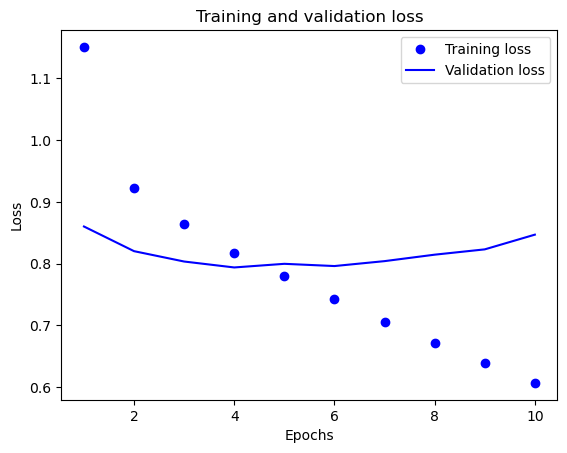

In [101]:
history_dict = history_c_4.history
train_val_loss(history_dict)

### 3.3.2 Model for fine

Loading the pre-trained model,

In [102]:
resnet50_f = ResNet50V2(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

Freezing the pre-trained layers to prevent them from being trained,

In [103]:
for layer in resnet50_f.layers:
    layer.trainable = False

Defining the model,

In [104]:
# Defining the model architecture
model_f_3 = keras.models.Sequential([
    resnet50_f,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),  
    keras.layers.Dense(50, activation="softmax")
])

Compiling the model,

In [105]:
# Compiling the model
model_f_3.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

Training the model,

In [106]:
# Define the filepath for saving the best model
checkpoint_path = 'deep_f_03.h5'

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [107]:
# Train the model
history_f_3 = model_f_3.fit(train_dl_fine,
                            validation_data=val_dl_fine,
                            callbacks=[model_checkpoint],
                            epochs=10)

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 3.0544 - accuracy: 0.2017
Epoch 1: val_accuracy improved from -inf to 0.28388, saving model to deep_f_03.h5
1563/1563 [==============================] - 2984s 2s/step - loss: 3.0544 - accuracy: 0.2017 - val_loss: 2.5966 - val_accuracy: 0.2839
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 2.6166 - accuracy: 0.2794
Epoch 2: val_accuracy improved from 0.28388 to 0.29578, saving model to deep_f_03.h5
1563/1563 [==============================] - 2964s 2s/step - loss: 2.6166 - accuracy: 0.2794 - val_loss: 2.5251 - val_accuracy: 0.2958
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 2.4424 - accuracy: 0.3187
Epoch 3: val_accuracy improved from 0.29578 to 0.30334, saving model to deep_f_03.h5
1563/1563 [==============================] - 2968s 2s/step - loss: 2.4424 - accuracy: 0.3187 - val_loss: 2.5155 - val_accuracy: 0.3033
Epoch 4/10
1563/1563 [===========================

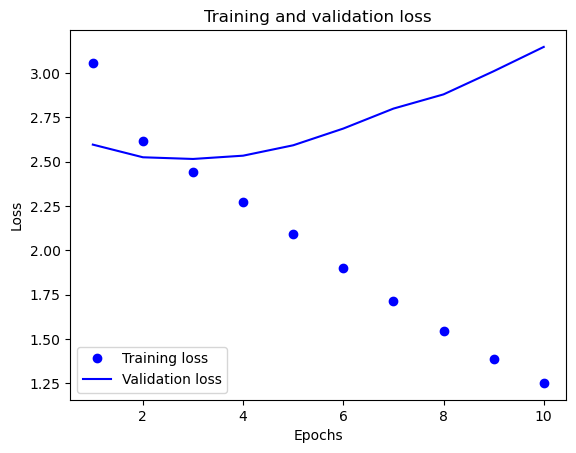

In [108]:
history_dict = history_f_3.history
train_val_loss(history_dict)

## 3.5 Predicting the public test set

### 3.5.1 Simple CNN Architecture

Model for coarse

In [109]:
# Load the best model
best_c_01 = keras.models.load_model("deep_c_01.h5")

In [110]:
y_pred_deep_c_01 = best_c_01.predict(test_dl_coarse)

782/782 [==============================] - 101s 129ms/step


In [111]:
# saving it into a csv format
y_pred_deep_c_01 = np.argmax(y_pred_deep_c_01, axis = 1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred_deep_c_01
test_csv = test_csv.drop(columns=['fine'])
pred_file = "47446730-deep-C01.csv"
test_csv.to_csv(pred_file, index = False)

In [112]:
y_pred_deep_c_01

array([4, 4, 4, ..., 0, 4, 4], dtype=int64)

The test accuracy is aligned with the validation accuracy at 59.602%.

In [113]:
best_c_02 = keras.models.load_model("deep_c_02.h5")

In [114]:
y_pred_deep_c_02 = best_c_02.predict(test_dl_coarse)

782/782 [==============================] - 135s 173ms/step


In [115]:
# saving it into a csv format
y_pred_deep_c_02 = np.argmax(y_pred_deep_c_02, axis = 1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred_deep_c_01
test_csv = test_csv.drop(columns=['fine'])
pred_file = "47446730-deep-C02.csv"
test_csv.to_csv(pred_file, index = False)

Model for fine

In [116]:
# Load the best model
best_f_01 = keras.models.load_model("deep_f_01.h5")

In [117]:
y_pred_deep_f_01 = best_f_01.predict(test_dl_fine)

782/782 [==============================] - 137s 175ms/step


In [118]:
# saving it into a csv format
y_pred_deep_f_01 = np.argmax(y_pred_deep_f_01, axis = 1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = y_pred_deep_f_01
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "47446730-deep-F01.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 15.036%.

### 3.5.2 VGG16

Model for coarse

In [119]:
# Load the best model
best_c_03 = keras.models.load_model("deep_c_03.h5")

In [120]:
y_pred_deep_c_03 = best_c_03.predict(test_dl_coarse)

782/782 [==============================] - 2608s 3s/step


In [121]:
# saving it into a csv format
y_pred_deep_c_03 = np.argmax(y_pred_deep_c_03, axis = 1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred_deep_c_03
test_csv = test_csv.drop(columns=['fine'])
pred_file = "47446730-deep-C03.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 65.708%.

Model for fine

In [122]:
# Load the best model
best_f_02 = keras.models.load_model("deep_f_02.h5")

In [123]:
y_pred_deep_f_02 = best_f_02.predict(test_dl_fine)

782/782 [==============================] - 2682s 3s/step


In [124]:
# saving it into a csv format
y_pred_deep_f_02 = np.argmax(y_pred_deep_f_02, axis = 1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = y_pred_deep_f_02
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "47446730-deep-F02.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 22.478%.

### 3.5.3 ResNet50V2

Model for coarse

In [125]:
# Load the best model
best_c_04 = keras.models.load_model("deep_c_04v2.h5")

In [126]:
y_pred_deep_c_04 = best_c_04.predict(test_dl_coarse)

782/782 [==============================] - 971s 1s/step


In [127]:
# saving it into a csv format
y_pred_deep_c_04 = np.argmax(y_pred_deep_c_04, axis = 1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred_deep_c_04
test_csv = test_csv.drop(columns=['fine'])
pred_file = "47446730-deep-C04.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 72.036%.

Model for fine

In [128]:
# Load the best model
best_f_03 = keras.models.load_model("deep_f_03.h5")

In [129]:
y_pred_deep_f_03 = best_f_03.predict(test_dl_fine)

782/782 [==============================] - 982s 1s/step


In [130]:
# saving it into a csv format
y_pred_deep_f_03 = np.argmax(y_pred_deep_f_03, axis = 1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"fine"] = y_pred_deep_f_03
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "47446730-deep-F03.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation accuracy at 32.23%.

## 3.6 Summary for Deep Learning

#### Training and Validation Loss - Fine-grained Data

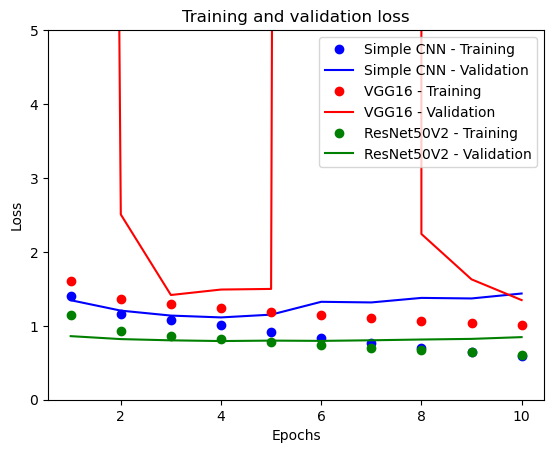

In [160]:
history_list = [history_c_2.history, history_c_3.history, history_c_4.history]
model_list = ["Simple CNN", "VGG16", "ResNet50V2"]
col_train = ["bo", "ro", "go"]
col_val = ["b", "r", "g"]

for i in range(3):
    acc = history_list[i]['accuracy']
    val_acc = history_list[i]['val_accuracy']
    loss = history_list[i]['loss']
    val_loss = history_list[i]['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, col_train[i], label=f'{model_list[i]} - Training')
    plt.plot(epochs, val_loss, col_val[i], label=f'{model_list[i]} - Validation')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend()

plt.show()

The loss for VGG16 can be seen to be extremely high in the beginning, this could be due to the lack of training data.

#### Training and Validation Loss - Fine-grained Data

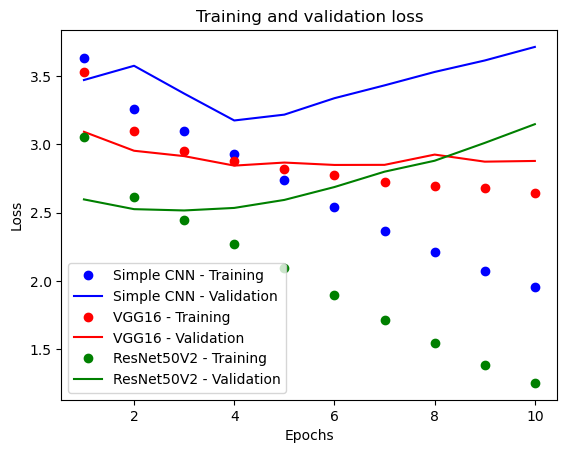

In [144]:
history_list = [history_f_1.history, history_f_2.history, history_f_3.history]
model_list = ["Simple CNN", "VGG16", "ResNet50V2"]
col_train = ["bo", "ro", "go"]
col_val = ["b", "r", "g"]

for i in range(3):
    acc = history_list[i]['accuracy']
    val_acc = history_list[i]['val_accuracy']
    loss = history_list[i]['loss']
    val_loss = history_list[i]['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, col_train[i], label=f'{model_list[i]} - Training')
    plt.plot(epochs, val_loss, col_val[i], label=f'{model_list[i]} - Validation')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Discussion on the models

There are a total of 3 type of models trained,
1. Simple CNN (without pre-trained model),
2. VGG16 as the pre-trained model with additional layers, and
3. ResNet50V2 as the pre-trained model with additional layers.

The rationale behind choosing these models is simple. For:
1. Simple CNN: It is always good to start training the data with the simplest model possible, one might say this is to see the base line. The structure itself is relatively simple with on convolutional neural network, a hidden dense layer, and an output layer. After training it, it can be observed that overfitting was happening (observed from its increasing validation loss and decreasing training loss on top of its poorer validation accuracy), thus we tried to add regularisation to the model using `BatchNormalization()` and `Dropout()`. As a result it can be observed that the model did indeed got better. However, we could have decreased the learning rate in order to improve the result further.
2. VGG16: It is a state-of-the-art model which has been trained using a huge amount of training data. Which is why we believe that this should have the best result. Although it was showing a significant improvement, it was taking too long to train, which is why the number of training data was reduced to 15% of the original training data. However, even with only 15% training data, the performance was improving almost with each epoch, but it was taking too long and we needed to cut short with just 10 epochs.
3. ResNet50V2: Based on my research via google, ResNet50V2 should be an improved version of ResNet50, which is why we have used this as our pre-trained model. The result is indeed satisfactory and the training time took way faster than using VGG16 with 15% of the training data.

In my opinion, VGG16 is indeed the better model, but in terms of usability, ResNet50V2 far outperforms VGG16. We could have fine tuned the ResNet50V2 model further by unfreezing some of its layer, but stopped because of how long it took to train it initially.

#### Discussion on the results

| **Data** | **Model**  | **Best Val Accuracy** | **Public Test Accuracy** |
| -------- | ---------- | --------------------- | ------------------------ |
| Coarse   | Simple CNN | 60.932%               | 59.602%                  |
| Coarse   | VGG16      | 56.317%               | 65.708%                  |
| Coarse   | ResNet50v2 | 72.234%               | 72.035%                  |
| Fine     | Simple CNN | 15.886%               | 15.036%                  |
| Fine     | VGG16      | 23.197%               | 22.478%                  |
| Fine     | ResNet50v2 | 30.394%               | 32.230%                  |


We have used the same deep learning structure for both coarse and fine data, but the models trained using the fine-grained data appear to be significantly worse than the coarse-grained data. This could be explained due to the model incapability to capture the subtle difference between the families of the same class. By decreasing the learing rate, adding more hidden layer and regularisation, the models performance would have been able to capture this subtlety.

# 4. Predicting the private test set

Since it can be observed that the deep learning model using the pre-trained model `ResNet50V2` is performing the best, we will be using it to classify the private test set.

In [131]:
# Creating the root path
root = Path('living-thing-classification-coarse-private/privtest_coarse')

In [132]:
priv_coarse = create_dataset_tf('coarse', fine_grained = False, batch_size = 64)
priv_fine = create_dataset_tf('fine', fine_grained = True, batch_size = 64)

## Coarse

In [133]:
# Load the best model
best_c_04 = keras.models.load_model("deep_c_04v2.h5")

In [134]:
y_pred_coarse = best_c_04.predict(priv_coarse)

24/24 [==============================] - 32s 1s/step


In [135]:
# saving it into a csv format
y_pred_coarse = np.argmax(y_pred_coarse, axis = 1)
test_csv = pd.read_csv(root / f"coarse.csv")
test_csv.loc[:,"coarse"] = y_pred_coarse
pred_file = "47446730-deep-C04-private.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation and public test accuracy at 71.133%.

## Fine

In [136]:
# Load the best model
best_f_03 = keras.models.load_model("deep_f_03.h5")

In [137]:
y_pred_fine = best_f_03.predict(priv_fine)

24/24 [==============================] - 32s 1s/step


In [138]:
# saving it into a csv format
y_pred_fine = np.argmax(y_pred_fine, axis = 1)
test_csv = pd.read_csv(root / f"fine.csv")
test_csv.loc[:,"fine"] = y_pred_fine
pred_file = "47446730-deep-F03-private.csv"
test_csv.to_csv(pred_file, index = False)

The test accuracy is aligned with the validation and public test accuracy 32.266%.

## Summary

| **Data** | **Model**  | **Private Test Accuracy** | **Public Test Accuracy** |
| -------- | ---------- | ------------------------- | ------------------------ |
| Coarse   | ResNet50v2 | 71.133%                   | 72.035%                  |
| Fine     | ResNet50v2 | 32.266%                   | 32.230%                  |

Since the model was not overfitting the public test accuracy, it can be observed that when classifying the images in the private test data, it is able to perform with a similar level of accuracy. This indicates that the model is able to generalise well to unseen data.

# 5. Reflection

After extensively training both conventional machine learning (ML) models and deep learning models, I have arrived at the conclusion that deep learning is indeed the superior choice for image classification tasks. Deep learning models have proven to be adept at capturing complex patterns and handling high dimensionality, making them highly effective for image classification.

When it comes to conventional ML models, one notable limitation is their ability to detect images in only two dimensions, typically black and white. This poses a challenge for classifying living things, as images can merge with the background when restricted to black and white. This limitation became evident through the poor performance observed in both validation and public tests. Conventional ML models also struggle to detect fine-grained labels accurately. While they may perform better on "clean" images with minimal background noise, the real-world images captured in this project contained various noisy components such as trees, grass, and rocks, which hindered their performance.

Furthermore, I encountered the issue of imbalanced data sets early on, particularly with the coarse-grained dataset. Although attempts were made to address this issue, it backfired as the model started overfitting the minor groups excessively, leading to a decline in accuracy for the major groups.

Using only 15% of the training data, the performance of the model trained with the Random Forest algorithm was approximately 50% for coarse-grained classification and 5% for fine-grained classification. While training with 100% of the data improved the results, it required an extensive 20-hour training time and yielded only around 65% accuracy for coarse-grained classification and 10% for fine-grained classification. Given the computational expense and minimal improvement, this approach was not deemed worthwhile.

I also attempted to employ Principal Component Analysis (PCA) to reduce noise but obtained worse results, which are not shown in this notebook. It seems that the noise present in the images, with numerous background elements, made it difficult for the model to effectively discern relevant features.

Despite the limitations and challenges faced during the training of conventional ML models, the experience was valuable. However, the results did not meet the initial expectations of achieving higher performance.

In contrast, deep learning models showed significant promise. Even without leveraging pre-trained models, the model achieved approximately 60% accuracy on the public test set. I experimented with state-of-the-art models such as VGG16 and ResNet50V2, but I believe their full potential was not realized due to my limited computing power. Given more computational resources, I could have lowered the learning rate and added more hidden layers to enhance the model's learning capacity. The loss graphs of the trained models indicate an issue of overfitting occurring too early, typically around the third or fifth epoch. Although I attempted to mitigate overfitting by incorporating Batch Normalization() and Dropout() layers, it was insufficient, and overfitting persisted.

During the fine-grained classification process, an interesting idea struck me. Considering that the coarse-grained models performed relatively well, I speculated that the number of labels might be a contributing factor. While the coarse-grained data had only eight labels, the fine-grained data consisted of 50 labels. This led me to consider training five models, each responsible for classifying ten labels, and employing ensemble techniques to combine their predictions. Unfortunately, I arrived at this realization rather late in the project timeline and was unable to test this theory.

In conclusion, I could have done better if I had known that training deep learning models take a really long time (maybe this is due to the lack of GPU). But comparing my results to the baseline and my peers, I feel confident that I am doing relatively well and have more rooms for improvements in my next machine learning projects.